# Classifying Early and Late stage KIRC tumors from the TCGA database

Replication of the study in [Jagga, Z. & Gupta, D. Classification models for clear cell renal carcinoma stage progression, based on tumor RNAseq expression trained supervised machine learning algorithms. BMC Proc. 8, S2 (2014)](http://bmcproc.biomedcentral.com/articles/10.1186/1753-6561-8-S6-S2)

Data locations:
- [Gene Expression Matrix](https://xenabrowser.net/datapages/?dataset=TCGA.KIRC.sampleMap%2FHiSeqV2&host=https%3A%2F%2Ftcga.xenahubs.net)
- [Clinical Metadata](https://xenabrowser.net/datapages/?dataset=TCGA.KIRC.sampleMap%2FKIRC_clinicalMatrix&host=https%3A%2F%2Ftcga.xenahubs.net)

In [56]:
# math
import pandas as pd
import numpy as np

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# sklearn utilities
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate

# classifiers
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, make_scorer
import sklearn.metrics as metrics

In [2]:
X_path = "./data/KIRC_gene_exp.tsv"
X_meta_path = "./data/KIRC_clinicalMatrix.tsv"

STAGE_COLUMN = "pathologic_stage"
GRADE_COLUMN = "neoplasm_histologic_grade"

SAMPLE_TYPE_COLUMN = "sample_type"

STAGE_I = "Stage I"
STAGE_II = "Stage II"
STAGE_III = "Stage III"
STAGE_IV = "Stage IV"
STAGES = [STAGE_I, STAGE_II, STAGE_III, STAGE_IV]

EARLY_STAGE = "Early_Stage"
LATE_STAGE = "Late_Stage"
NORMAL = "Normal"

PRIMARY_TUMOR_TYPE = "Primary Tumor"
SOLID_TISSUE_NORMAL = "Solid Tissue Normal"

class_encoding = {
    EARLY_STAGE: 0,
    LATE_STAGE: 1,
    NORMAL: 2
}

class_decoding = {v: k for k, v in class_encoding.items()}

In [3]:
X_exp = pd.read_csv(X_path, sep="\t").set_index("sample").T
X_meta = pd.read_csv(X_meta_path, sep="\t").set_index("sampleID")

We divide the stages in two classes:
- *Early stage*: Stage 1 and Stage 2
- *Late stage*: Stage 3 and Stage 4

We consider only the samples which are labeled as "Primary Tumor"

In [4]:
def stage_to_class(stage):
    if stage in [STAGE_I, STAGE_II]:
        return class_encoding[EARLY_STAGE]
    else:
        return class_encoding[LATE_STAGE]
    
def encode_class(c):
    return class_encoding[c]

def decode_class(c):
    return class_decoding[c]

patients = X_meta[X_meta[STAGE_COLUMN].isin(STAGES) & \
                  (X_meta[SAMPLE_TYPE_COLUMN] == PRIMARY_TUMOR_TYPE)].index\
            .intersection(X_exp.index).tolist()

normal_samples = X_meta[(X_meta[SAMPLE_TYPE_COLUMN] == SOLID_TISSUE_NORMAL)].index\
            .intersection(X_exp.index).tolist()

print("# patients with {} and {}: {}".format(PRIMARY_TUMOR_TYPE, ", ".join(STAGES), len(patients)))

X_meta_s = X_meta.loc[patients]

X = X_exp.loc[patients].as_matrix()
X_n = X_exp.loc[normal_samples].as_matrix()
y = np.array(X_meta_s[STAGE_COLUMN].map(stage_to_class).tolist())
y_n = [class_encoding[NORMAL] for _ in range(X_n.shape[0])]
X_with_normal = np.append(X, X_n, axis=0)
y_with_normal = np.append(y, y_n)

assert X.shape[0] == y.shape[0], "X and y have different number of samples"

idx_to_patient = pd.Series(index=np.arange(len(patients)), data=patients)
patient_to_idx = pd.Series(data=np.arange(len(patients)), index=patients)

# patients with Primary Tumor and Stage I, Stage II, Stage III, Stage IV: 531


## Statistics

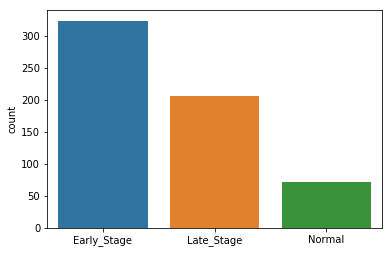

In [5]:
sns.countplot(list(map(decode_class, y)) + ['Normal' for _ in range(len(normal_samples))])
plt.show()

In [6]:
colormap = {
    class_encoding[LATE_STAGE]: 'red',
    class_encoding[EARLY_STAGE]: 'blue',
    class_encoding[NORMAL]: 'green'
}

named_colormap = {class_decoding[k] : v for k, v in colormap.items()}

def plot_PCA(X, y):
    pca = PCA(n_components=2)
    X_t = pca.fit_transform(X)
    colors = list(map(lambda x: colormap[x], y))
    plt.figure(figsize=(10, 10))
    ax = sns.regplot(x=X_t[:, 0], y=X_t[:, 1], fit_reg=False, scatter_kws={'color': colors, 's': 50})
    return ax

def plot_legend(ax, colormap):
    legend_elements = []
    for k, v in colormap.items():
        legend_elements.append(Line2D([0], [0], color=v, lw=4, label=k))
    ax.legend(handles=legend_elements)

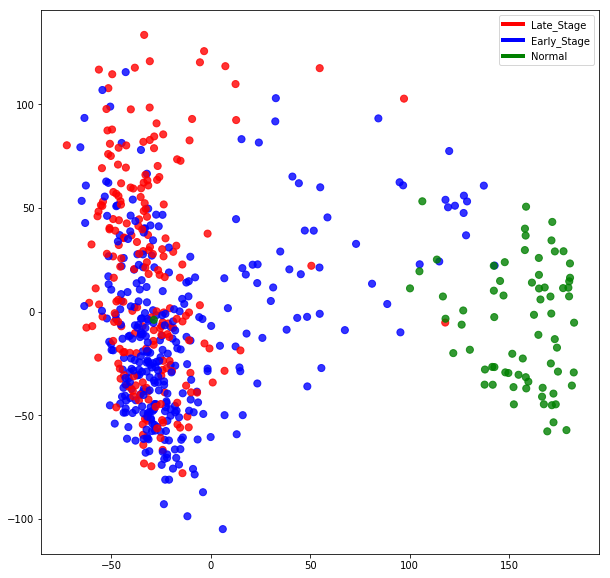

In [7]:
ax = plot_PCA(X_with_normal, y_with_normal)
plot_legend(ax, named_colormap)
plt.show()

The two classes are very mixed up and both of them are pretty different from the normal samples.

## Cross-Validation Pipeline

We perform a 10-fold-CV evaluation

### Model:

1. **Pre-processing**: nothing
2. **Classifier**: SVC

### Performance metrics:

- Accuracy
- Sensitivity
- MCC
- F1-score
- Area under the ROC

In [86]:
pipeline = Pipeline(steps=[
    ("classifier", SVC())
])

name_labels = [EARLY_STAGE, LATE_STAGE]
labels = list(map(lambda x: class_encoding[x], name_labels))


def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred, labels)[0, 0]
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred, labels)[1, 1]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred, labels)[1, 0]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred, labels)[0, 1]

scoring = {
    'TRUE_ES': make_scorer(tp),
    'TRUE_LS': make_scorer(tn),
    'FALSE_ES': make_scorer(fp),
    'FLASE_LS': make_scorer(fn),
    
    'accuracy': make_scorer(metrics.accuracy_score),
    'sensitivity': make_scorer(metrics.recall_score, average="weighted"),
    'MCC': make_scorer(metrics.matthews_corrcoef),
    'f-score': make_scorer(metrics.f1_score, average="weighted"),
    'auROC': make_scorer(metrics.roc_auc_score, average="weighted")
}

In [87]:
scores = cross_validate(estimator=pipeline, scoring=scoring, X=X, y=y, cv=10, n_jobs=10, return_train_score=False)

In [74]:
def get_confusion_matrix(scores):
    test_TRUE_ES = scores['test_TRUE_ES'].sum()
    test_TRUE_LS = scores['test_TRUE_LS'].sum()
    test_FALSE_ES = scores['test_FALSE_ES'].sum()
    test_FLASE_LS = scores['test_FLASE_LS'].sum()
    
    d = np.array([[test_TRUE_ES, test_FALSE_ES], 
                  [test_FLASE_LS, test_TRUE_LS]])
    return d

def cm_to_df(d):
    r = pd.DataFrame(data=d, index=name_labels, columns=name_labels)
    r.index.name = "Actual"
    r.columns.name = "Predicted"
    return r

In [104]:
def get_aggregate_measures(scores):
    res = {
        'accuracy': scores['test_accuracy'],
        'sensitivity': scores['test_sensitivity'],
        'MCC': scores['test_MCC'],
        'f-score': scores['test_f-score'],
        'auROC': scores['test_auROC']
    }
    return pd.DataFrame.from_dict(res)

In [106]:
get_aggregate_measures(scores).mean()

MCC            0.413970
accuracy       0.726171
auROC          0.689965
f-score        0.713950
sensitivity    0.726171
dtype: float64